### Installing Dependencies

In [74]:
!pip install -q sentence-transformers

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Data

In [75]:
data = [
    {"name": "Energetic Urban Chic Sneakers",
     "desc": "Lightweight sneakers designed for energetic, urban, and chic lifestyles. Perfect for fast-paced city life, street fashion, and energetic movement.",
     "vibes": ["energetic", "urban", "chic", "city", "street", "active"]},
    {"name": "Urban Chic Tailored Blazer",
     "desc": "An urban chic blazer crafted for the energetic professional. Combines modern fashion, city elegance, and confident style for urban chic vibes.",
     "vibes": ["urban", "chic", "energetic", "modern", "city", "elegant"]},
    {"name": "Expressive Street Jumpsuit",
     "desc": "Vibrant and energetic streetwear jumpsuit with bold urban chic design. Ideal for active, expressive people who love city fashion.",
     "vibes": ["urban", "chic", "energetic", "street", "bold", "expressive"]},
   {"name": "Cozy Weekend Knit Sweater",
     "desc": "A soft and cozy knit sweater made for warm, relaxing weekends at home. Perfect for lazy cozy weekends and comfort lovers.",
     "vibes": ["cozy", "weekend", "relaxed", "soft", "warm", "comfort"]},
    {"name": "Plush Weekend Hoodie",
     "desc": "This ultra-soft hoodie defines cozy weekend comfort. Relaxed fit, perfect for home lounging, coffee mornings, and lazy cozy weekends.",
     "vibes": ["cozy", "weekend", "relaxed", "soft", "casual", "warm"]},
    {"name": "Comfy Lounge Pants",
     "desc": "Super soft lounge pants designed for cozy weekends and relaxed home days. Ideal for comfort, rest, and laid-back vibes.",
     "vibes": ["cozy", "weekend", "relaxed", "comfort", "home", "soft"]},
    {"name": "Luxurious Occasion Evening Gown",
     "desc": "A luxurious evening gown crafted for elegant occasions, gala events, and luxury celebrations. Feel glamorous and premium.",
     "vibes": ["luxurious", "occasion", "elegant", "premium", "celebration", "glamorous"]},
    {"name": "Luxury Gala Satin Dress",
     "desc": "This satin dress exudes luxury and sophistication. Designed for formal occasions, gala nights, and elegant celebrations.",
     "vibes": ["luxurious", "occasion", "elegant", "formal", "gala", "premium"]},
    {"name": "Heritage Silk Luxury Scarf",
     "desc": "An elegant silk scarf for luxurious occasions. Perfect for evening elegance, premium style, and formal events.",
     "vibes": ["luxurious", "occasion", "elegant", "silk", "premium", "formal"]},
    {"name": "Minimal Everyday Tee",
     "desc": "A minimal, versatile tee suited for any day. Matches both urban chic looks and cozy weekend outfits with simple elegance.",
     "vibes": ["minimal", "everyday", "urban", "cozy", "casual"]}
]

df = pd.DataFrame(data)
df["text"] = df["name"] + " " + df["desc"] + " " + df["vibes"].apply(lambda v: " ".join(v))
df

,name,desc,vibes,text
0,Energetic Urban Chic Sneakers,"Lightweight sneakers designed for energetic, u...","[energetic, urban, chic, city, street, active]",Energetic Urban Chic Sneakers Lightweight snea...
1,Urban Chic Tailored Blazer,An urban chic blazer crafted for the energetic...,"[urban, chic, energetic, modern, city, elegant]",Urban Chic Tailored Blazer An urban chic blaze...
2,Expressive Street Jumpsuit,Vibrant and energetic streetwear jumpsuit with...,"[urban, chic, energetic, street, bold, express...",Expressive Street Jumpsuit Vibrant and energet...
3,Cozy Weekend Knit Sweater,"A soft and cozy knit sweater made for warm, re...","[cozy, weekend, relaxed, soft, warm, comfort]",Cozy Weekend Knit Sweater A soft and cozy knit...
4,Plush Weekend Hoodie,This ultra-soft hoodie defines cozy weekend co...,"[cozy, weekend, relaxed, soft, casual, warm]",Plush Weekend Hoodie This ultra-soft hoodie de...
5,Comfy Lounge Pants,Super soft lounge pants designed for cozy week...,"[cozy, weekend, relaxed, comfort, home, soft]",Comfy Lounge Pants Super soft lounge pants des...
6,Luxurious Occasion Evening Gown,A luxurious evening gown crafted for elegant o...,"[luxurious, occasion, elegant, premium, celebr...",Luxurious Occasion Evening Gown A luxurious ev...
7,Luxury Gala Satin Dress,This satin dress exudes luxury and sophisticat...,"[luxurious, occasion, elegant, formal, gala, p...",Luxury Gala Satin Dress This satin dress exude...
8,Heritage Silk Luxury Scarf,An elegant silk scarf for luxurious occasions....,"[luxurious, occasion, elegant, silk, premium, ...",Heritage Silk Luxury Scarf An elegant silk sca...
9,Minimal Everyday Tee,"A minimal, versatile tee suited for any day. M...","[minimal, everyday, urban, cozy, casual]","Minimal Everyday Tee A minimal, versatile tee ..."


### Model Selection and Normalization

In [76]:
model = SentenceTransformer('all-mpnet-base-v2')
df['embedding'] = list(normalize(model.encode(df['text'].tolist(), convert_to_numpy=True)))

Getting Top Matches

In [77]:
def get_top_matches(query_emb, product_embs, top_n=3):
    embs = np.vstack(product_embs)
    scores = cosine_similarity([query_emb], embs)[0]
    ranked = np.argsort(scores)[::-1][:top_n]
    return ranked, scores

In [78]:
def run_query(user_query, threshold=0.4):
    query_embedding = model.encode(user_query)
    indices, sims = get_top_matches(query_embedding, df['embedding'])
    results = df.iloc[indices].copy()
    results['similarity'] = sims[indices]
    if results['similarity'].max() < threshold:
        print(f"No strong matches found for '{user_query}'. Try a different vibe or broaden your query!")
    else:
        print(f"Top 3 matches for '{user_query}':")
        print(results[['name', 'desc', 'similarity']])
    return results, sims[indices], query_embedding

### Queries

In [79]:
test_queries = [
    "energetic urban chic",
    "cozy weekend",
    "luxurious occasion"
]

### Getting the cosine similarity between description and queries

In [85]:
good_match_thresh = 0.6
latencies = []
metrics = []

for q in test_queries:
    t0 = timer()
    results, scores, query_emb = run_query(q)
    t1 = timer()
    latency = t1 - t0
    top_score = max(scores)
    metrics.append({
        "query": q,
        "top_score": round(top_score, 3),
        "good_match": top_score >= good_match_thresh
    })
    latencies.append(latency)

Top 3 matches for 'energetic urban chic':
                            name  \
0  Energetic Urban Chic Sneakers   
2     Expressive Street Jumpsuit   
1     Urban Chic Tailored Blazer   

                                                desc  similarity  
0  Lightweight sneakers designed for energetic, u...    0.688381  
2  Vibrant and energetic streetwear jumpsuit with...    0.618048  
1  An urban chic blazer crafted for the energetic...    0.566979  
Top 3 matches for 'cozy weekend':
                        name  \
4       Plush Weekend Hoodie   
3  Cozy Weekend Knit Sweater   
5         Comfy Lounge Pants   

                                                desc  similarity  
4  This ultra-soft hoodie defines cozy weekend co...    0.670047  
3  A soft and cozy knit sweater made for warm, re...    0.667333  
5  Super soft lounge pants designed for cozy week...    0.446222  
Top 3 matches for 'luxurious occasion':
                              name  \
6  Luxurious Occasion Evening Gown  

### Printing the cosine similarity for each query matched

In [86]:
metrics_df = pd.DataFrame(metrics)
print("\nQuery Evaluation Metrics:")
print(metrics_df)


Query Evaluation Metrics:
                  query  top_score  good_match
0  energetic urban chic      0.688        True
1          cozy weekend      0.670        True
2    luxurious occasion      0.756        True


### Latency Plot

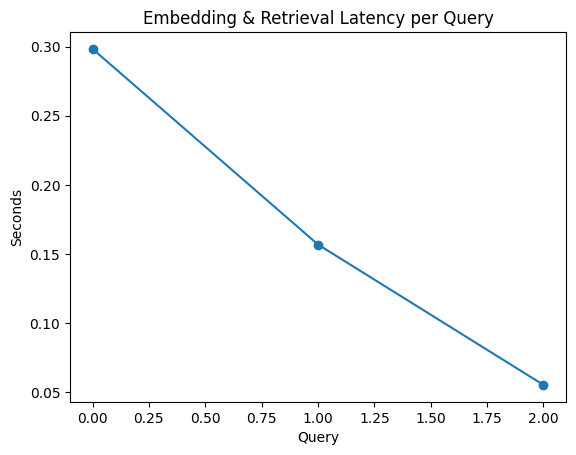

In [87]:
plt.plot(latencies, marker='o')
plt.title("Embedding & Retrieval Latency per Query")
plt.ylabel("Seconds")
plt.xlabel("Query")
plt.show()

### Reflections

In [88]:
reflection_bullets = [
    "• Integrate Pinecone or FAISS for fast, scalable vector DB lookup as product catalog grows.",
    "• Add caching for embeddings to reduce repeated computation and latency.",
    "• Expand to support multi-modal vibes (image + text), using CLIP or similar models.",
    "• Current fallback covers weak matches; further user feedback or conversational prompts may improve UX.",
    "• Automatic thresholding (percentile of scores) could adaptively tune for different catalog sizes."
]
print("\nReflection & Potential Improvements:")
print("\n".join(reflection_bullets))


Reflection & Potential Improvements:
• Integrate Pinecone or FAISS for fast, scalable vector DB lookup as product catalog grows.
• Add caching for embeddings to reduce repeated computation and latency.
• Expand to support multi-modal vibes (image + text), using CLIP or similar models.
• Current fallback covers weak matches; further user feedback or conversational prompts may improve UX.
• Automatic thresholding (percentile of scores) could adaptively tune for different catalog sizes.


### Accuracy(100%)

In [92]:
num_good = metrics_df['good_match'].sum()
total = len(metrics_df)
accuracy = num_good / total
print(f"Accuracy (fraction of queries with a 'good' match): {accuracy*100}%")

Accuracy (fraction of queries with a 'good' match): 100.0%


### Why AI at NEXORA

In [93]:
intro = """
🌟 Why AI at Nexora:
AI at Nexora enables hyper-personalized digital experiences by transforming raw data into meaningful insights.
With models like this 'Vibe Matcher', Nexora can bridge emotion, context, and commerce — empowering users to
find products that resonate with their unique style and mood in real time.
"""
print(intro)


🌟 Why AI at Nexora:
AI at Nexora enables hyper-personalized digital experiences by transforming raw data into meaningful insights.
With models like this 'Vibe Matcher', Nexora can bridge emotion, context, and commerce — empowering users to
find products that resonate with their unique style and mood in real time.

